In [1]:
import re
from collections import Counter
from typing import List, Tuple

import pandas as pd
import numpy as np
import spacy
import seaborn as sns
from scipy.spatial.distance import cosine

# download the first time
# !spacy download "en_core_web_sm"

## 1. import data

In [2]:
DATA_PATH = "../data/interim/targets_data.csv"
df = pd.read_csv(DATA_PATH)

pd.set_option("display.max_colwidth", None)

df['Date of Event'] = df['Date of Event'].astype(int, errors='ignore')  

columns_drop = [
    "Who's Adding the Target", 
    'Date of Entry', 
    # 'Target ID', 
    # 'Document ID',
    # 'Country Name', 
    # 'GHG/NON-GHG', 
    # 'Sector', 
    # 'Target Scope', 
    # 'Target Type',   
    # 'Is Target Per Capita?', 
    'Target Summary', 
    # 'Target Description',
    'Target Signals', 
    # 'Target Page Number',
    'Page Numbers: PDF or Document?', 
    'Target Base Year Period',
    'Target Year', 
    'Single or Multi-Year Target', 
    # 'Date of Event',
    'Comments / Further Information - instruments, errors, etc'
]

df = df.drop(columns=columns_drop)

df_not_targets = df[~df['is_target']]
df = df[df['is_target']]

In [3]:
rnd_seed = 142
nlp = spacy.load("en_core_web_sm")

## 2. EDA

### 2.1 descriptive statistics

In [4]:
print(f"Total num targets: {len(df)}")

duplicates = df.loc[df.duplicated('Target Description'), 'Target Description']
print(f"Duplicated targets: {len(duplicates.unique())} ({len(duplicates)} if counting duplicates as separate targets)" )

Total num targets: 319
Duplicated targets: 8 (10 if counting duplicates as separate targets)


**for the rest of this notebook we drop rows with duplicate target text**

In [5]:
df = df.drop_duplicates(subset='Target Description')
len(df)

309

### 2.2 years and year ranges

> about 2/3 of targets contain mentions of years. 23 of these year mentions are year ranges rather than individual years

In [6]:
def get_years(val: str) -> bool:
    # exclude vals=0: there is a 3,0000 figure in the data
    return [int(i) for i in re.findall(r"\d{4}", val) if 0 < int(i) < 2100]

def contains_year_range(val: str) -> bool:
    return bool(
        # 2008-9 or 2009-10 or 2009-2010
        re.findall(r"\d{4}-\d{1,2}", val) + re.findall(r"\d{4}-\d{4}", val) + re.findall(r"\d{4} to \d{4}", val)
    )

df['_years'] = df["Target Description"].apply(get_years)
df["_contains_year"] = df['_years'].apply(bool)
df['_max_year'] = df['_years'].apply(lambda l: max(l) if l else np.nan)
df['_max_year_ge_doc_created'] = df['_max_year'] >= df['Date of Event']
df['_contains_year_range'] = df["Target Description"].apply(contains_year_range)

df.groupby(["_contains_year", "_contains_year_range"]).count()["Target Description"]

_contains_year  _contains_year_range
False           False                   132
True            False                   154
                True                     23
Name: Target Description, dtype: int64

> most targets contain (max) years that are in the future. Where they don't, this tends to be:
* a metadata issue (e.g. a document is a later revision),
* because the year isn't the target year, or .
* because the document is referring to a target that was created in a previous document, or
* because the year isn't in a target (e.g. it's in the name of another policy that's referenced).

_max_year_ge_doc_created
False     7
True     74
Name: Document ID, dtype: int64

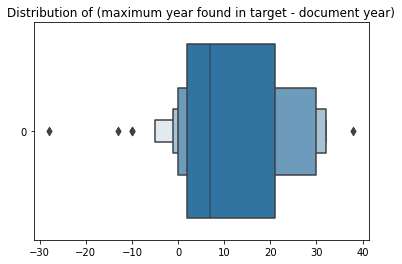

In [7]:
display(df[df['_contains_year'] & df['Date of Event']].groupby('_max_year_ge_doc_created').count()["Document ID"])

sns.boxenplot(data=df['_max_year'] - df["Date of Event"], orient="h").set_title("Distribution of (maximum year found in target - document year)");

### 2.3 figures that aren't years

> most targets contain a numerical non-year value (date, cardinal, quantity or percent) - there are some false negatives in this count too

In [8]:
ent_types = ("DATE", "CARDINAL", "QUANTITY", "PERCENT", "ORDINAL")

ent_col_names = []
ent_bool_col_names = []

for idx, row in df.iterrows():
    doc = nlp(row["Target Description"])
    
    for ent_type in ent_types:
        # exclude years
        ent_vals = [ent.text for ent in doc.ents if ent.label_ == ent_type if not get_years(ent.text)]
        
        col_name = f"_ents_{ent_type.lower()}"
        ent_col_names.append(col_name)
        df.at[idx, col_name] = ent_vals or np.nan
        
    df.at[idx, "_n_sentences"] = len(list(doc.sents))
    
for ent_type in ent_types:
    boolean_col_name = f'_contains_{ent_type.lower()}_ent'
    ent_bool_col_names.append(boolean_col_name)
    
    df[boolean_col_name] = df[f'_ents_{ent_type.lower()}'].notnull()
    display(df.groupby(boolean_col_name).count()["Document ID"])
    
# maximum and minimum
print("------------------------------")
for v in ("minimum", "maximum"):
    bool_col = f'_contains_{v}'
    df[bool_col] = df['Target Description'].apply(lambda i: v in i.lower())

    display(df.groupby(bool_col).count()["Document ID"])

_contains_date_ent
False    269
True      40
Name: Document ID, dtype: int64

_contains_cardinal_ent
False    177
True     132
Name: Document ID, dtype: int64

_contains_quantity_ent
False    295
True      14
Name: Document ID, dtype: int64

_contains_percent_ent
False    169
True     140
Name: Document ID, dtype: int64

_contains_ordinal_ent
False    294
True      15
Name: Document ID, dtype: int64

------------------------------


_contains_minimum
False    295
True      14
Name: Document ID, dtype: int64

_contains_maximum
False    308
True       1
Name: Document ID, dtype: int64

> targets that contain combinations of numerical entities are most likely to contain a combination of cardinal and percent figures, followed by percent and date figures

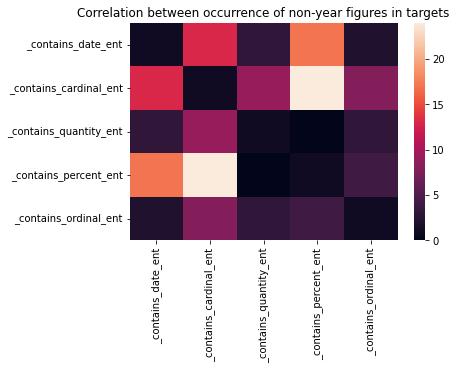

In [9]:
sns.heatmap(df[ent_bool_col_names].corr(method=np.dot)).set_title("Correlation between occurrence of non-year figures in targets");

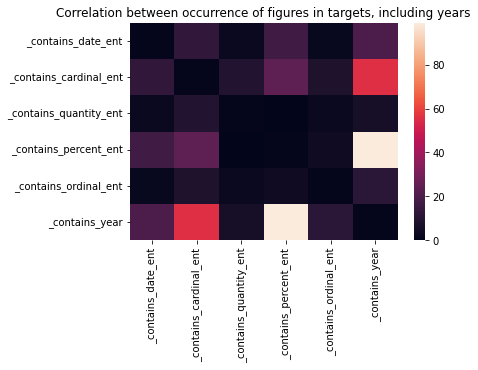

In [10]:
sns.heatmap(df[ent_bool_col_names + ["_contains_year"]].corr(method=np.dot)).set_title(
    "Correlation between occurrence of figures in targets, including years");

> most of the non-year dates talk mention 'annual(ly)' or 'n years'

In [11]:
sorted(df.loc[df['_contains_date_ent'], "_ents_date"].sum())

['15 years',
 '5 years',
 '5 years',
 '5 years',
 '80 years',
 'Annually',
 'Five Year Plan',
 'Monthly',
 'The target year',
 'a\ndecade',
 'a year',
 'annual',
 'annual',
 'annual',
 'annual',
 'annual',
 'annual',
 'annually',
 'annually',
 'close to 80 years',
 'five years',
 'five-year',
 'five-year',
 'that same decade',
 'that year',
 'that year',
 'the 75th year',
 'the coming decades',
 'the coming years',
 'the current year',
 'the end of the',
 'the next 15 years',
 'the next 5 years',
 'the next 5 years',
 'the next five years',
 'the next five years',
 'the next five years',
 'the year',
 'the year',
 'the year',
 'the year',
 'those years',
 'today']

### 2.4 Number of sentences

> most targets are 1 sentence long. The vast majority are 1 or 2 sentences long.

In [12]:
df.groupby(["_n_sentences"]).count()["Document ID"]

_n_sentences
1.0    276
2.0     30
3.0      3
Name: Document ID, dtype: int64

In [13]:
# some targets with 3 or 2 sentences
df.sort_values('_n_sentences', ascending=False).head(5)[[col for col in df.columns if not col.startswith("_")]]

,Target ID,Document ID,Document md5sum,Country Name,GHG/NON-GHG,Sector,Target Scope,Target Type,Is Target Per Capita?,Target Description,Target Page Number,Date of Event,Unnamed: 22,Sheet Name,Target Description (original language),temp translated,is_target
163,167.0,9532,80d3af8046604f57f72e76e92db6b05d,Bhutan,GHG,Economy-wide,Carbon neutrality,Fixed level target,No,"Carbon Neutral Declaration: The “Declaration of the Kingdom of Bhutan - The Land of Gross National Happiness to Save our Planet” made by the Kingdom of Bhutan in 2009 and reaffirmed in 2015 is a unilateral declaration and may have the status of international customary law. Therefore, as far as the obligations of Bhutan are concerned; the commitment to ensure GHG emissions remain below forest sinks must be fulfilled.",10,2020,NaN,verified-docs,NaN,NaN,True
39,31.0,10368,396697fc7f530c667a87d96f7ae21cf4,Kyrgyzstan,Non-GHG,Social development,NaN,Fixed level target,No,"Vision: By 2040, the economic well-being of the people will be guaranteed by creating productive jobs that provide decent employment and stable incomes. 80% of working population will have decent wages and labor conditions. Kyrgyzstan is among the top 60 countries with a high UNDP Human Development Index.",30,2018,NaN,verified-docs,NaN,NaN,True
70,66.0,10368,396697fc7f530c667a87d96f7ae21cf4,Kyrgyzstan,Non-GHG,Health,Health services,Fixed level target,No,Construction of perinatal center in Bishkek funded by the German Government. ✓ Construction of neurosurgical center of the National Hospital of the Ministry of Health of the Kyrgyz Republic. ✓ Construction of the surgical building of the city children’s clinical emergency hospital.,112,2018,NaN,verified-docs,NaN,NaN,True
84,79.0,10368,396697fc7f530c667a87d96f7ae21cf4,Kyrgyzstan,Non-GHG,Health,Health services,Fixed level target,No,✓ Modernization of 16 family medicine centers and equipping them with modern equipment. ✓ Modernization of multidisciplinary hospital with modern equipment for high-level emergency care,115,2018,NaN,verified-docs,NaN,NaN,True
250,NaN,10245,NaN,Guniea,Non-GHG,Economy-wide,NaN,Fixed level target,No,"Objective 6.4: Ensure regional integration in sustainable development.By 2040, the value of exchanges with neighboring countries goes from 3% to 30%.",66,2019,NaN,non-english-language,"Objectif 6.4 : Assurer l’intégration régionale en matière de développement durable. D’ici 2040, la valeur des échanges avec les pays limitrophes passe de 3% à 30%.","Objective 6.4: Ensure regional integration in sustainable development. By 2040, the value of exchanges with neighboring countries goes from 3% to 30%.",True


### 2.5 common ngrams

In [14]:
import string
import random
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

# input the reuters sentences
sents = df['Target Description'].tolist()
 
# write the removal characters such as : Stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = string.punctuation

tokens_remove = list(stop_words) + list(punctuation)

def process_sentence(sent: str) -> str:
    """Remove stopwords and punctuation"""
    
    return " ".join([tok for tok in word_tokenize(sent) if tok not in tokens_remove])
    
def get_ngrams(sentence: str, n: int) -> List[Tuple[str]]:
    sent_split = sentence.lower().split()
    
    if n == 1:
        return sent_split
    else:
        return list(ngrams(
            sent_split, 
            n, 
            pad_left=False, 
            pad_right=False,
        ))
    
df['_target_no_stopwords'] = df['Target Description'].apply(process_sentence)
df[['_unigrams', '_bigrams', '_trigrams']] = ""

for idx, row in df.iterrows():
    unigrams = get_ngrams(row["_target_no_stopwords"], 1)
    bigrams = get_ngrams(row["_target_no_stopwords"], 2)
    trigrams = get_ngrams(row["_target_no_stopwords"], 3)
    
    df.at[idx, '_unigrams'] = unigrams
    df.at[idx, '_bigrams'] = bigrams
    df.at[idx, '_trigrams'] = trigrams

all_unigrams = df['_unigrams'].sum()
all_bigrams = df['_bigrams'].sum()
all_trigrams = df['_trigrams'].sum()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kalyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


> the most common ngrams seem to be overfitting to the longest document in the dataset

In [15]:
print("unigrams")
display(Counter(all_unigrams).most_common(10))

print("\nbigrams")
display(Counter(all_bigrams).most_common(10))

print("\ntrigrams")
display(Counter(all_trigrams).most_common(10))


unigrams


[('energy', 104),
 ('the', 62),
 ('✓', 49),
 ('2030', 48),
 ('renewable', 40),
 ('least', 39),
 ('new', 38),
 ('reduction', 35),
 ('2050', 35),
 ('electricity', 29)]


bigrams


[(('energy', 'consumption'), 20),
 (('renewable', 'energy'), 17),
 (('water', 'supply'), 13),
 (('drinking', 'water'), 12),
 (('✓', 'construction'), 12),
 (('✓', 'modernization'), 12),
 (('modern', 'equipment'), 12),
 (('specific', 'energy'), 12),
 (('irrigated', 'land'), 11),
 (('thousand', 'hectares'), 10)]


trigrams


[(('new', 'irrigated', 'land'), 9),
 (('hectares', 'new', 'irrigated'), 8),
 (('specific', 'energy', 'consumption'), 8),
 (('relative', '2015', 'baseline'), 8),
 (('greenhouse', 'gas', 'emissions'), 8),
 (('family', 'medicine', 'centers'), 7),
 (('social', 'assistance', 'centers'), 7),
 (('assistance', 'centers', 'disadvantaged'), 7),
 (('centers', 'disadvantaged', 'families'), 7),
 (('disadvantaged', 'families', 'children'), 7)]

#### ngrams containing years

> targets commonly contain the phrases *compared to xxxx*, *relative to xxxx*, *xxxx baseline*, *xxxx relative to yyyy* , or *by xxxx*

In [16]:
bigrams_with_year = [g for g in all_bigrams if any([re.match(r"\d{4}", word) for word in g])]
trigrams_with_year = [g for g in all_trigrams if any([re.match(r"\d{4}", word) for word in g])]

print("bigrams containing year")
display(Counter(bigrams_with_year).most_common(10))

print("\ntrigrams containing year")
display(Counter(trigrams_with_year).most_common(10))

bigrams containing year


[(('compared', '1990'), 10),
 (('relative', '2015'), 8),
 (('2015', 'baseline'), 8),
 (('2030', 'relative'), 7),
 (('neutrality', '2050'), 7),
 (('20', '2030'), 5),
 (('by', '2023'), 4),
 (('set', '2019-20'), 3),
 (('end', '2023'), 3),
 (('10', '2022'), 3)]


trigrams containing year


[(('relative', '2015', 'baseline'), 8),
 (('2030', 'relative', '2015'), 7),
 (('climatic', 'neutrality', '2050'), 4),
 (('climate', 'neutrality', '2050'), 3),
 (('2030', "'s", 'horizon'), 3),
 (('corporation', 'set', '2019-2020'), 2),
 (('rural', 'households', '2024'), 2),
 (('new', 'clusters', '2019-20'), 2),
 (('incubators', 'tbis', '2019-20'), 2),
 (('tbis', '2019-20', 'develop'), 2)]

#### ngram frequency split by GHG/non-GHG

> words and phrases like 'carbon neutral(ity)' seem to indicate that a phrase is a greenhouse gas target. However, this is unlikely to be a useful predictor for whether any phrase is a target.

In [17]:
df.groupby("GHG/NON-GHG").count()["Document ID"]

GHG/NON-GHG
GHG         36
Non-GHG    265
Name: Document ID, dtype: int64

In [18]:
for ghg_val in ("GHG", "Non-GHG"):
    print(ghg_val)
    display(Counter(df.loc[df['GHG/NON-GHG'] == ghg_val, "_unigrams"].sum()).most_common(10))
    display(Counter(df.loc[df['GHG/NON-GHG'] == ghg_val, "_bigrams"].sum()).most_common(10))
    print()

GHG


[('2050', 21),
 ('emissions', 18),
 ('carbon', 17),
 ('energy', 13),
 ('neutrality', 13),
 ('reduction', 12),
 ('compared', 12),
 ('1990', 12),
 ('climate', 10),
 ('the', 10)]

[(('compared', '1990'), 10),
 (('greenhouse', 'gas'), 8),
 (('carbon', 'neutral'), 7),
 (('gas', 'emissions'), 7),
 (('remain', 'carbon'), 5),
 (('carbon', 'neutrality'), 5),
 (('climate', 'neutrality'), 5),
 (('neutrality', '2050'), 5),
 (('paris', 'agreement'), 4),
 (('achieving', 'carbon'), 4)]


Non-GHG


[('energy', 87),
 ('the', 50),
 ('✓', 49),
 ('renewable', 35),
 ('2030', 34),
 ('new', 33),
 ('least', 32),
 ('water', 28),
 ('consumption', 28),
 ('electricity', 27)]

[(('energy', 'consumption'), 20),
 (('renewable', 'energy'), 15),
 (('water', 'supply'), 13),
 (('drinking', 'water'), 12),
 (('✓', 'construction'), 12),
 (('✓', 'modernization'), 12),
 (('modern', 'equipment'), 12),
 (('specific', 'energy'), 12),
 (('irrigated', 'land'), 11),
 (('thousand', 'hectares'), 10)]